# Unsupervised Segmentation of Anomalies in Images

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms, models

# Image Augmentation

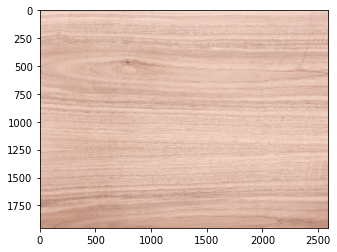

In [2]:
sample_image = datasets.ImageFolder('./data')[0][0]
width, height = sample_image.size
plt.imshow(sample_image)

In [3]:
image_transforms = [
  transforms.Compose([transforms.ToTensor()]),
  transforms.Compose([transforms.CenterCrop((height//2, width//2)), transforms.Resize((height, width)), transforms.ToTensor()]),
  transforms.Compose([transforms.RandomCrop((height//2, width//2)), transforms.Resize((height, width)), transforms.ToTensor()]),
  transforms.Compose([transforms.RandomHorizontalFlip(1.0), transforms.ToTensor()]),
  transforms.Compose([transforms.RandomVerticalFlip(1.0), transforms.ToTensor()]),
  transforms.Compose([transforms.GaussianBlur(kernel_size=(3,3)), transforms.ToTensor()]),
]

In [4]:
list_datasets = []
for transform in image_transforms:
  dataset = datasets.ImageFolder('./data', transform=transform)
  list_datasets.append(dataset)
augmented_dataset = torch.utils.data.ConcatDataset(list_datasets)
dataloader = torch.utils.data.DataLoader(augmented_dataset)
print(f"Number of images in the augmented dataset is {len(dataloader)}")

Number of images in the augmented dataset is 42


# Configuring the autoencoder

I have used a Convolutional Autoencoder for the purpose of unsupervised segmentation of anomalies in images. 
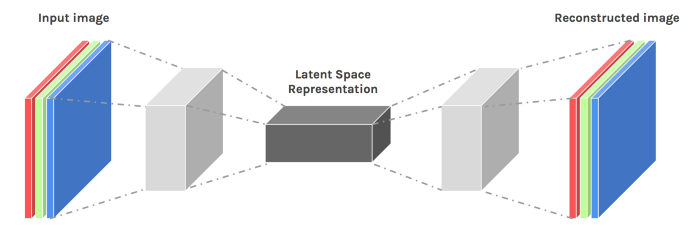

The neural network I am using is fairly simple as shown above. There is a convolution encoder layer that receives an input color image of a wooden section, and outputs a latent representation which has 128 channels. This latent representation compresses the essential characteristics of the input image while leaving out anomalous information such as knots and spots. Then a deconvolution decoder layer is used to decompress the latent representation and reconstruct the image, albeit with missing anomalies. By comparing the pixel values of input and the output images, it's possible to locate the points of interest. 

The reason such kind of method is effective is because the convolution filters are shared for all the regions of images. Since by definition, anomalies are rare in the image compared to other regions, such convolution filters only learn recurring texture information if the network is trained for very small number of epochs. When these filters encounter anomalous regions of image, their output is not able to match with the input.

In [5]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU() # Activation function
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=3, stride=2, output_padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU()
        )
    
    def forward(self, input_image, gts=None):
        encoded_image = self.encoder(input_image)
        decoded_image = self.decoder(encoded_image)
        return decoded_image

# Output of Untrained Network

In [6]:
untrained_net = MyNet().eval()
sample_image, _ = next(iter(dataloader))
input_image = sample_image[0][None, :, :, :]  # Add extra dimension
output_image = untrained_net.forward(input_image).detach() 

# Dimensions of input and output images should be the same
print(f"Size of input image is {input_image.size()}")
print(f"Size of output image is {output_image.size()}")

Size of input image is torch.Size([1, 3, 1952, 2592])
Size of output image is torch.Size([1, 3, 1952, 2592])


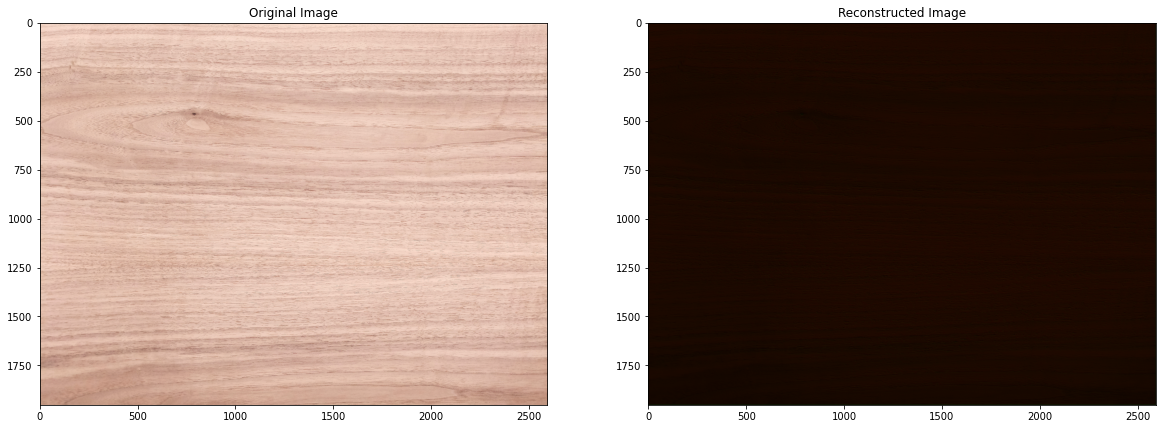

In [7]:
input_image = input_image[0].permute(1, 2, 0)
output_image = output_image[0].permute(1, 2, 0)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Original Image')
ax1.imshow(input_image)
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Reconstructed Image')
ax2.imshow(output_image)

# Training the Autoencoder

In [8]:
def get_optimizer(net, lr):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return optimizer

In [9]:
def train(net, x, y, optimizer, criterion):
    net.zero_grad()
    output = net(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    return loss, output

In [10]:
net = MyNet() # Initialize an untrained network
net = net.cuda() # Utilize Colab's GPU
optm = get_optimizer(net, lr=0.1)
criterion = nn.MSELoss()
EPOCHS = 1

for epoch in range(EPOCHS):
    epoch_loss = 0
    for img, _ in dataloader:
      img = img.cuda()
      loss, predictions = train(net, img, img, optm, criterion)
      epoch_loss += loss
print(f'Average MSE Loss per image: {epoch_loss/len(dataloader)}')
net = net.eval()

Average MSE Loss per image: 0.06539411097764969


# Display input and reconstructed images

In [11]:
def display_images(dataset, index):
  sample_image, _ = augmented_dataset[index]
  input_image = sample_image[None, :, :, :]  # Add extra dimension
  output_image = net.forward(input_image.cuda()).detach() 
  input_image = input_image[0].permute(1, 2, 0)
  output_image = output_image[0].cpu().permute(1, 2, 0)
  fig = plt.figure(figsize=(20,10))
  ax1 = fig.add_subplot(1,2,1)
  ax1.set_title('Original Image')
  ax1.imshow(input_image)
  ax2 = fig.add_subplot(1,2,2)
  ax2.set_title('Reconstructed Image')
  ax2.imshow(output_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


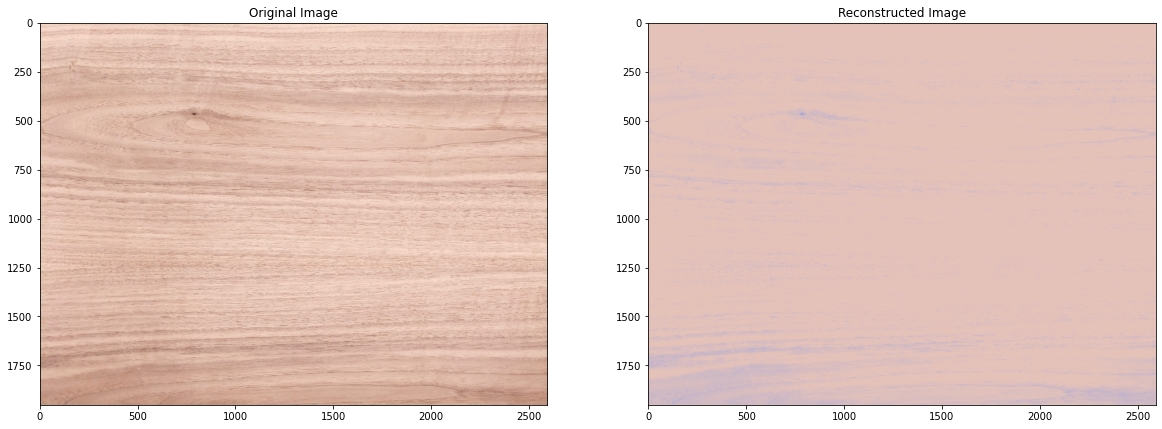

In [12]:
display_images(augmented_dataset, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


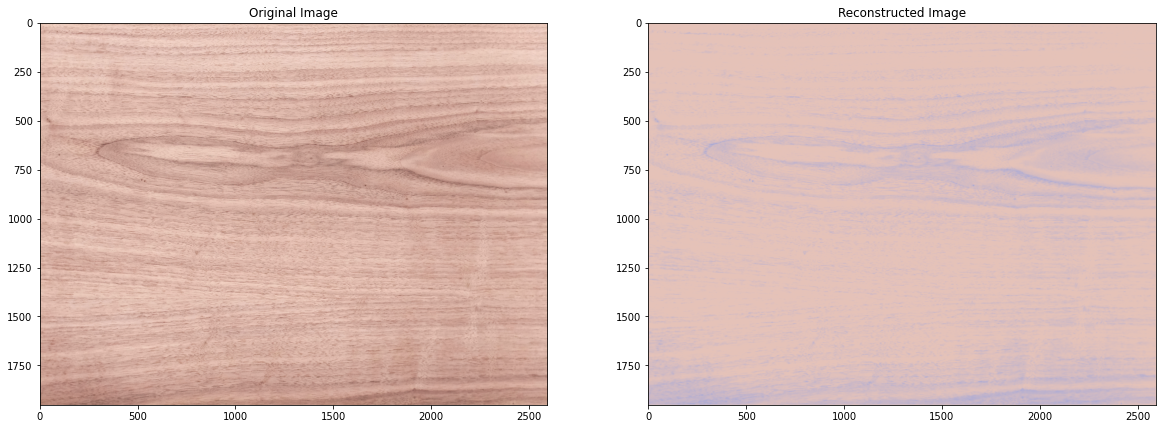

In [13]:
display_images(augmented_dataset, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


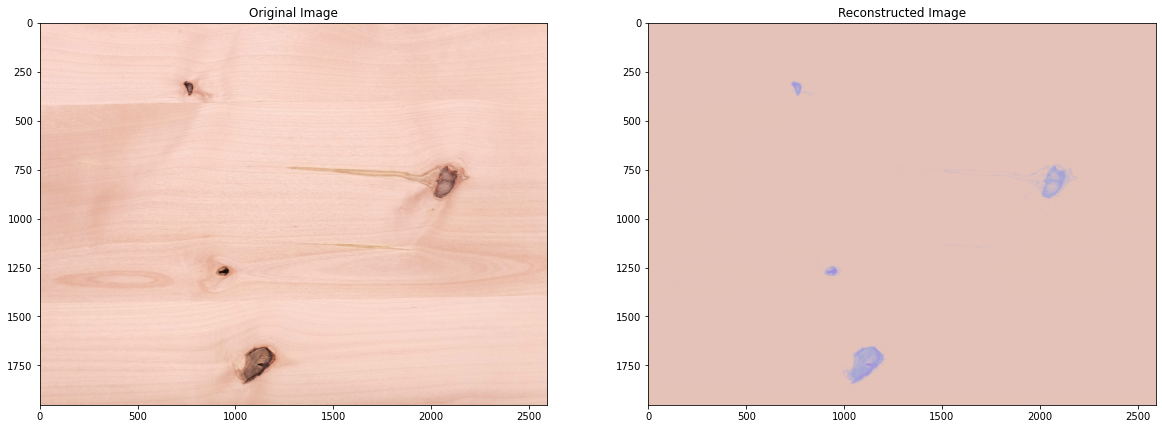

In [14]:
display_images(augmented_dataset, 2)

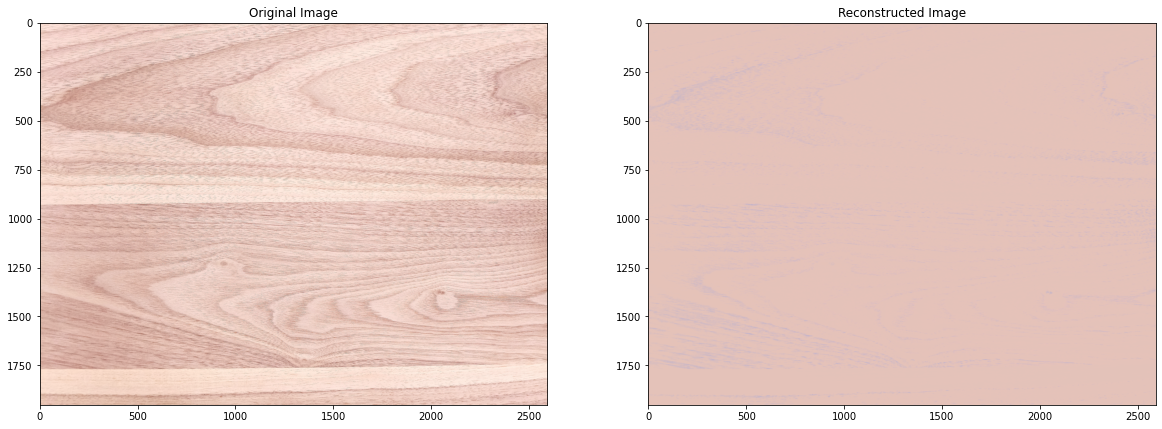

In [15]:
display_images(augmented_dataset, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


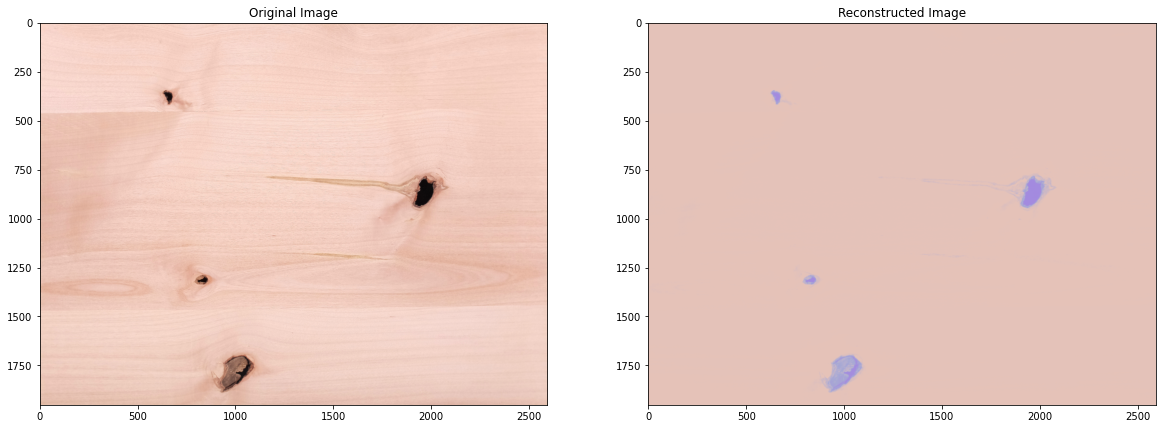

In [16]:
display_images(augmented_dataset, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


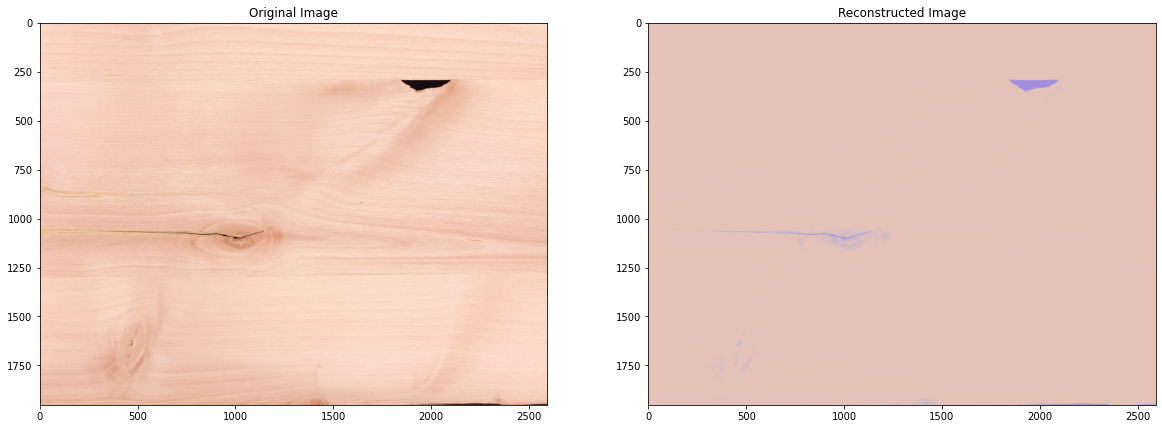

In [17]:
display_images(augmented_dataset, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


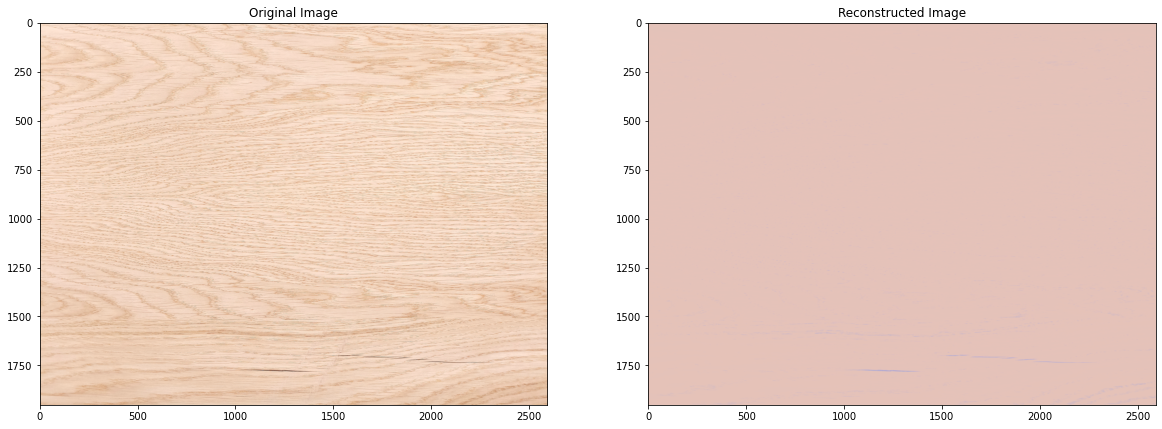

In [18]:
display_images(augmented_dataset, 6)

# Conclusion

Through this simple Autoencoder, it was possible to locate regions of interest in the wooden surfaces. This model could be further enhanced by collecting more images of different types of wooden surfaces and having deeper networks. For any other type of surface, a good starting point would be to use the learned weights of this autoencoder and retrain the network with the images for the new kind of surface. 